In [2]:
#import libraries.
import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.wrappers.scikit_learn import KerasRegressor
import keras
from keras import regularizers
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from keras.initializers import glorot_normal
# import sounddevice as sd
import tensorflow as tf
from mir_eval import separation 
from pystoi.stoi import stoi 
import h5py
from keras.callbacks import LearningRateScheduler
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
import math
from sklearn.utils import shuffle
from sklearn import preprocessing
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [3]:
#import libraries.
# import matplotlib.pyplot as plt
# from tabulate import tabulate
import time
import os
import librosa
from librosa.core import stft, istft
import time
import pickle
from keras import backend as K
from tensorflow.keras.models import load_model
# from keras.models import load_model

In [4]:
def loss_DNNC(y_true, y_pred, Lambda = 0.05):
    loss = K.sum(K.square(y_true - y_pred)) 
    - Lambda * K.sum(K.square(y_true[0:257,:] - y_pred[0:257,:]) + K.square(y_true[257:,:] - y_pred[257:,:]))
    return loss

In [5]:
def reconstruct(wave,angle):
    recon1 = wave*np.cos(angle)+wave*np.sin(angle)*1j
#     recon = np.sqrt(np.power(10, wave))
#     recon1 = recon*np.cos(angle)+recon*np.sin(angle)*1j
    recon = librosa.core.istft((recon1.T), hop_length=160, win_length=400, window='hann')
    return recon

In [6]:
data_series = str(4)

In [16]:
h5f = h5py.File('TIMIT/Organized/Two_stage_sec_set/predicted_sec_set.hdf5','r')
X = h5f['predicted_sec_set'][:]
h5f.close()
print(X.shape)

(514, 295522)


In [17]:
h5f = h5py.File('TIMIT/Organized/concatenated/clean'  + data_series + '_sec.hdf5','r')
y = h5f['clean'  + data_series + '_sec'][:]
h5f.close()
print(y.shape)

(514, 295522)


In [18]:
h5f = h5py.File('TIMIT/Organized/concatenated/valid_mixed'  + data_series + '.hdf5','r')
X_valid = h5f['valid_mixed'  + data_series ][:]
h5f.close()
print(X_valid.shape)

(55383, 257)


In [19]:
h5f = h5py.File('TIMIT/Organized/concatenated/valid_clean'  + data_series + '.hdf5','r')
y_valid = h5f['valid_clean'  + data_series ][:]
h5f.close()
print(y_valid.shape)

(55383, 514)


In [20]:
np.linalg.norm(X[:,0])

0.121167555

In [21]:
X_train = preprocessing.normalize(X, norm='l2', axis=0, copy=True)
y_train = preprocessing.normalize(y, norm='l2', axis=0, copy=True)

In [22]:
X_valid = preprocessing.normalize(X_valid, norm='l2', axis=0, copy=True)

In [23]:
estimator_A = load_model('Models/Two_stage/trained_model19.h5')
prediction = estimator_A.predict(X_valid)
prediction0 = np.multiply(X_valid, prediction[:,0:257])
prediction1 = np.multiply(X_valid, prediction[:,257:])
X_valid = np.concatenate((prediction0, prediction1), axis=1)

In [24]:
X_valid = preprocessing.normalize(X_valid, norm='l2', axis=0, copy=True)
y_valid = preprocessing.normalize(y_valid, norm='l2', axis=0, copy=True)

In [25]:
print(X.shape)
print(y.shape)
print(X_valid.shape)
print(X_valid.shape)


(514, 295522)
(514, 295522)
(55383, 514)
(55383, 514)


In [29]:
X_dim= 514
y_dim = 514
h_C = [1028, 1028, 1028]
def DNN_C():
    # create model
    model = Sequential()
    model.add(Dense(h_C[0], input_dim = X_dim, kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(h_C[1], kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(h_C[2], kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(y_dim, kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

In [30]:
batch_size = 100
tic = time.time()
estimator_C = KerasRegressor(build_fn=DNN_C, epochs = 200, batch_size=batch_size, shuffle = True, verbose=1)
# kfold = KFold(n_splits=2, random_state=None)
# kfold = KFold(n_splits=5)
# results = cross_val_score(estimator_A, X.T, y.T, cv=kfold)
# print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
# toc_fold = time.time()

print("^^^^^^^^^^^^^^^^^^^^^ Training on mixed5^^^^^^^^^^^^^^^^^^^^^")
# filepath="half_trained.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor = 'loss', verbose = 0, save_best_only = True, mode = 'min') 
# callbacks_list = [checkpoint]
history = estimator_C.fit(X.T, y.T, validation_data=(X_valid, y_valid), shuffle = True, batch_size=batch_size,  steps_per_epoch=None)
toc_adam = time.time()
# print("---------------------------second part of training---------------------------")
# new_model = load_model(filepath)
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save?_best_only=True, mode='min')
# callbacks_list = [checkpoint]
# new_model.optimizer = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
# new_model.fit(X.T, Mask.T, shuffle = True, epochs = 100, batch_size=100,  steps_per_epoch=None, callbacks=callbacks_list)
# estimator_A.fit (X.T, y.T, shuffle = True, batch_size=100,  steps_per_epoch=None, callbacks = [changer])
# prediction = estimator_A.predict(X_test)

toc_fit = time.time()

^^^^^^^^^^^^^^^^^^^^^ Training on mixed5^^^^^^^^^^^^^^^^^^^^^
Train on 295522 samples, validate on 55383 samples
Epoch 1/200
295522/295522 [==============================] - 22s 75us/step - loss: 0.0349 - val_loss: 4.9948e-05
Epoch 2/200
295522/295522 [==============================] - 23s 76us/step - loss: 0.0286 - val_loss: 0.0017
Epoch 3/200
295522/295522 [==============================] - 21s 73us/step - loss: 0.0276 - val_loss: 0.0012
Epoch 4/200
295522/295522 [==============================] - 22s 74us/step - loss: 0.0269 - val_loss: 5.5100e-04
Epoch 5/200
295522/295522 [==============================] - 23s 78us/step - loss: 0.0264 - val_loss: 3.0740e-04
Epoch 6/200
295522/295522 [==============================] - 21s 71us/step - loss: 0.0260 - val_loss: 7.3724e-04
Epoch 7/200
295522/295522 [==============================] - 22s 76us/step - loss: 0.0256 - val_loss: 9.4125e-04
Epoch 8/200
295522/295522 [==============================] - 21s 72us/step - loss: 0.0254 - val_loss: 9.

295522/295522 [==============================] - 22s 74us/step - loss: 0.0191 - val_loss: 0.0017
Epoch 75/200
295522/295522 [==============================] - 22s 74us/step - loss: 0.0191 - val_loss: 0.0021
Epoch 76/200
295522/295522 [==============================] - 23s 78us/step - loss: 0.0190 - val_loss: 0.0020
Epoch 77/200
295522/295522 [==============================] - 22s 74us/step - loss: 0.0190 - val_loss: 0.0017
Epoch 78/200
295522/295522 [==============================] - 23s 79us/step - loss: 0.0189 - val_loss: 0.0019
Epoch 79/200
295522/295522 [==============================] - 22s 75us/step - loss: 0.0189 - val_loss: 0.0015
Epoch 80/200
295522/295522 [==============================] - 22s 74us/step - loss: 0.0188 - val_loss: 0.0012
Epoch 81/200
295522/295522 [==============================] - 23s 77us/step - loss: 0.0188 - val_loss: 0.0015
Epoch 82/200
295522/295522 [==============================] - 22s 76us/step - loss: 0.0187 - val_loss: 0.0012
Epoch 83/200
295522/295

295522/295522 [==============================] - 21s 72us/step - loss: 0.0169 - val_loss: 0.0014
Epoch 149/200
295522/295522 [==============================] - 23s 78us/step - loss: 0.0166 - val_loss: 0.0018
Epoch 150/200
295522/295522 [==============================] - 22s 75us/step - loss: 0.0166 - val_loss: 0.0015
Epoch 151/200
295522/295522 [==============================] - 23s 77us/step - loss: 0.0166 - val_loss: 0.0012
Epoch 152/200
295522/295522 [==============================] - 24s 82us/step - loss: 0.0165 - val_loss: 0.0017
Epoch 153/200
295522/295522 [==============================] - 24s 80us/step - loss: 0.0165 - val_loss: 0.0014
Epoch 154/200
295522/295522 [==============================] - 22s 74us/step - loss: 0.0165 - val_loss: 0.0012
Epoch 155/200
295522/295522 [==============================] - 22s 75us/step - loss: 0.0165 - val_loss: 0.0015
Epoch 156/200
295522/295522 [==============================] - 23s 78us/step - loss: 0.0166 - val_loss: 0.0015
Epoch 157/200
2

In [31]:
estimator_C.model.save('Models/Two_stage/Model1_C0.h5')

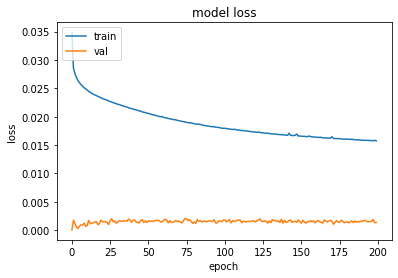

In [32]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
print('Time= ', (toc_fit - tic)/60)

Time=  74.59687539339066
